# CIPS-Net Training with Permutation-Based Dataset
## Language-Conditional Compositional Pathology Segmentation

This notebook trains CIPS-Net with the **permutations-based dataset** where:
- Each image has **2^N - 1** instances (N = number of classes in that image)
- Each instance has a **different text query** asking for specific class(es)
- The model learns to segment **ONLY** the classes mentioned in the query
- This enables true **text-conditional compositional segmentation**

### Key Difference from Unique Labels:
- **Unique**: "Segment Neoplastic and Inflammatory" → ALL present masks loaded
- **Permutations**: Same image can have:
  - "Segment Neoplastic" → ONLY Neoplastic mask, others are ZERO
  - "Segment Inflammatory" → ONLY Inflammatory mask, others are ZERO  
  - "Segment Neoplastic and Inflammatory" → Both masks loaded

In [1]:
# Cell 1: Imports and Path Setup
import sys
sys.path.append('CIPS-Net')

import torch
import torch.nn as nn
from models.cips_net import CIPSNet
from torchinfo import summary
import numpy as np

print("✓ Base imports loaded!")

✓ Base imports loaded!


In [2]:
# Cell 2: Reload CIPS-Net modules
import importlib

# Remove cached modules to pick up any changes
modules_to_reload = [
    'CIPS-Net.models.image_encoder',
    'CIPS-Net.models.text_encoder',
    'CIPS-Net.models.instruction_grounding',
    'CIPS-Net.models.decoder',
    'CIPS-Net.models.cips_net',
    'CIPS-Net.models'
]

for module_name in modules_to_reload:
    if module_name in sys.modules:
        del sys.modules[module_name]

# Re-import
from models.cips_net import CIPSNet
print("✓ CIPS-Net modules reloaded!")

✓ CIPS-Net modules reloaded!


## 1. Initialize CIPS-Net Model

In [3]:
# Cell 3: Initialize CIPS-Net Model
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")
BASE_PATH = "Dataset"
# Initialize model
print("\nInitializing CIPS-Net for Language-Conditional Compositional Segmentation...")
print("📦 ViT-B/16 + DistilBERT")

model = CIPSNet(
    img_encoder_name='vit_b_16',
    text_encoder_name="emilyalsentzer/Bio_ClinicalBERT",   # distilbert-base-uncased
    embed_dim=768,
    num_classes=5,
    img_size=224,
    num_graph_layers=3,
    decoder_channels=[512, 256, 128, 64],
    freeze_text_encoder=False,
    pretrained=False
)

print("✓ Model initialized successfully!")

Using device: cuda

Initializing CIPS-Net for Language-Conditional Compositional Segmentation...
📦 ViT-B/16 + DistilBERT
✓ Model initialized successfully!
✓ Model initialized successfully!
✓ Model initialized successfully!


## 2. Model Information

In [4]:
# Cell 4: Model Information
model_info = model.get_model_info()

print("="*80)
print("CIPS-NET MODEL INFORMATION")
print("="*80)

for key, value in model_info.items():
    if key == 'class_names':
        print(f"\n{key}:")
        for i, name in enumerate(value):
            print(f"  {i}. {name}")
    elif key in ['total_parameters', 'trainable_parameters']:
        print(f"{key}: {value:,}")
    else:
        print(f"{key}: {value}")

CIPS-NET MODEL INFORMATION
model_name: CIPS-Net
image_encoder: vit_b_16
text_encoder: emilyalsentzer/Bio_ClinicalBERT
embed_dim: 768
num_classes: 5
img_size: 224
total_parameters: 162,548,741
trainable_parameters: 162,548,741

class_names:
  0. Neoplastic
  1. Inflammatory
  2. Connective_Soft_tissue
  3. Epithelial
  4. Dead
  5. Background


## 3. Test Forward Pass

In [5]:
# Cell 5: Test Forward Pass
print("Testing forward pass with compositional queries...")

# Move model to device
model = model.to(device)
model.eval()

# Test with different compositional queries
test_queries = [
    "Segment Neoplastic tissue",
    "Segment Inflammatory and Connective_Soft_tissue",
    "Segment Neoplastic and Inflammatory and Dead",
]

batch_size = 2
test_images = torch.randn(batch_size, 3, 224, 224).to(device)
test_instructions = test_queries[:batch_size]

with torch.no_grad():
    outputs = model(test_images, test_instructions)
    pred_masks = outputs['masks']

print(f"\nInput shape: {test_images.shape}")
print(f"Output shape: {pred_masks.shape}")
print(f"Expected: [B, 5, 224, 224] = [{batch_size}, 5, 224, 224]")
print("\n✓ Forward pass successful!")

Testing forward pass with compositional queries...

Input shape: torch.Size([2, 3, 224, 224])
Output shape: torch.Size([2, 5, 224, 224])
Expected: [B, 5, 224, 224] = [2, 5, 224, 224]

✓ Forward pass successful!

Input shape: torch.Size([2, 3, 224, 224])
Output shape: torch.Size([2, 5, 224, 224])
Expected: [B, 5, 224, 224] = [2, 5, 224, 224]

✓ Forward pass successful!

Input shape: torch.Size([2, 3, 224, 224])
Output shape: torch.Size([2, 5, 224, 224])
Expected: [B, 5, 224, 224] = [2, 5, 224, 224]

✓ Forward pass successful!


## 4. Load Permutation-Based Dataset

**Key Change**: Loading `Images_With_Permutations_Labels_Refer_Segmentation_Task.csv` instead of unique labels.

Each image now has **2^N - 1 instances** where N is the number of classes in that image.

In [6]:
# Cell 6: Training Libraries
import pandas as pd
from PIL import Image
import cv2
from sklearn.model_selection import train_test_split
from torch.utils.data import Dataset, DataLoader
from tqdm.auto import tqdm
import albumentations as A
from albumentations.pytorch import ToTensorV2
import torch.nn.functional as F
from torch.optim import AdamW
from torch.optim.lr_scheduler import CosineAnnealingLR
import matplotlib.pyplot as plt
import os
from datetime import datetime

print("Training libraries imported!")

Training libraries imported!


In [7]:
# Cell 7: Load Permutation-Based Dataset
# ============================================
# KEY CHANGE: Using permutations CSV instead of unique labels
# ============================================

df = pd.read_csv('Dataset/Images_With_Permutations_Labels_Refer_Segmentation_Task.csv')
print(f"Dataset loaded: {len(df)} total instances (image + text query combinations)")
print(f"\nColumns: {df.columns.tolist()}")

# Count unique images
unique_images = df['image_path'].nunique()
print(f"\nUnique images: {unique_images}")
print(f"Average instances per image: {len(df) / unique_images:.1f}")

# Class names
class_names = ['Neoplastic', 'Inflammatory', 'Connective_Soft_tissue', 'Epithelial', 'Dead']
CLASS_NAMES = class_names
# Parse classes column (semicolon-separated) into binary columns
# NOTE: This is for QUERIED classes in each instance, not ALL classes in image
for class_name in class_names:
    df[class_name] = df['classes'].apply(lambda x: 1 if class_name in str(x).split(';') else 0)

# Add base_name for mask path construction
df['base_name'] = df['image_path'].str.replace('_img.png', '', regex=False)

# Show class query distribution
print(f"\n📊 Class Query Distribution (how often each class is QUERIED):")
for col in class_names:
    count = df[col].sum()
    print(f"  {col}: {count} queries ({count/len(df)*100:.1f}%)")

# Show sample rows
print(f"\n📝 Sample instances (same image, different queries):")
sample_image = df['image_path'].iloc[0]
sample_df = df[df['image_path'] == sample_image]
print(f"Image: {sample_image}")
print(f"Number of query instances: {len(sample_df)}")
for i, (_, row) in enumerate(sample_df.iterrows()):
    print(f"  {i+1}. Classes: {row['classes']}")
    print(f"     Instruction: {row['instruction'][:80]}...")

Dataset loaded: 24326 total instances (image + text query combinations)

Columns: ['image_id', 'image_path', 'classes', 'organ', 'classes_clean', 'instruction']

Unique images: 2720
Average instances per image: 8.9

📊 Class Query Distribution (how often each class is QUERIED):
  Neoplastic: 11978 queries (49.2%)
  Inflammatory: 12592 queries (51.8%)
  Connective_Soft_tissue: 13389 queries (55.0%)
  Epithelial: 7252 queries (29.8%)
  Dead: 2078 queries (8.5%)

📝 Sample instances (same image, different queries):
Image: 1_Breast_fold_1_0000_img.png
Number of query instances: 7
  1. Classes: Connective_Soft_tissue
     Instruction: This Breast falls into Connective_Soft_tissue....
  2. Classes: Inflammatory
     Instruction: The Breast histopathology reveals Inflammatory....
  3. Classes: Neoplastic
     Instruction: Here we have a Breast with Neoplastic....
  4. Classes: Connective_Soft_tissue;Inflammatory
     Instruction: Outline pathological margins of Connective_Soft_tissue and Inflam

In [8]:
# Cell 8: Permutation-Aware Dataset Class
# ============================================
# KEY CHANGE: Load masks ONLY for classes mentioned in the query
# Other class masks are forced to be ZERO (even if mask file exists)
# ============================================

class HistopathologyPermutationDataset(Dataset):
    """
    Dataset for Language-Conditional Compositional Segmentation.
    
    Each instance has:
    - An image
    - A text query asking for specific class(es)
    - Masks ONLY for the queried classes (other channels are ZERO)
    
    This forces the model to learn text-conditional segmentation:
    - Same image with "Segment Neoplastic" -> only channel 0 has mask
    - Same image with "Segment Inflammatory" -> only channel 1 has mask
    - Same image with "Segment Neoplastic and Inflammatory" -> channels 0,1 have masks
    
    MASK NAMING CONVENTION:
    - Actual masks: {base_name}_channel_{channel_idx}_{class_name}.png
    - e.g., 1_Breast_fold_1_0000_channel_0_Neoplastic.png
    """
    
    def __init__(self, dataframe, img_dir='Dataset/multi_images', mask_dir='Dataset/multi_masks', 
                 transform=None, img_size=224):
        self.df = dataframe.reset_index(drop=True)
        self.img_dir = img_dir
        self.mask_dir = mask_dir
        self.transform = transform
        self.img_size = img_size
        self.class_names = ['Neoplastic', 'Inflammatory', 'Connective_Soft_tissue', 'Epithelial', 'Dead']
        # Channel mapping matches the mask file naming convention
        self.channel_mapping = {
            'Neoplastic': 0,
            'Inflammatory': 1,
            'Connective_Soft_tissue': 2,
            'Dead': 3,        # Note: In files, Dead is channel 3
            'Epithelial': 4   # Note: In files, Epithelial is channel 4
        }
        
    def __len__(self):
        return len(self.df)
    
    def __getitem__(self, idx):
        row = self.df.iloc[idx]
        
        # Load image
        img_path = os.path.join(self.img_dir, row['image_path'])
        image = cv2.imread(img_path)
        if image is None:
            raise FileNotFoundError(f"Image not found: {img_path}")
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        
        # ============================================
        # Parse QUERIED classes from semicolon-separated string
        # ============================================
        queried_classes = set(str(row['classes']).split(';'))
        
        # Load masks ONLY for queried classes
        # base_name comes from image_path without '_img.png' suffix
        base_name = row['base_name']
        masks = []
        
        for class_name in self.class_names:
            channel_idx = self.channel_mapping[class_name]
            
            # ============================================
            # Only load mask if class is in the query
            # Otherwise, use empty mask (zeros)
            # ============================================
            if class_name in queried_classes:
                # This class is queried - load the actual mask
                # CORRECT pattern: {base_name}_channel_{channel_idx}_{class_name}.png
                mask_filename = f"{base_name}_channel_{channel_idx}_{class_name}.png"
                mask_path = os.path.join(self.mask_dir, mask_filename)
                
                if os.path.exists(mask_path):
                    mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)
                    mask = (mask > 127).astype(np.uint8)  # Binarize
                else:
                    # Mask file doesn't exist - class may not be present in image
                    mask = np.zeros((image.shape[0], image.shape[1]), dtype=np.uint8)
            else:
                # This class is NOT queried - FORCE empty mask
                # Even if the mask file exists, we don't load it
                mask = np.zeros((image.shape[0], image.shape[1]), dtype=np.uint8)
            
            masks.append(mask)
        
        # Stack masks: [H, W, num_classes]
        masks = np.stack(masks, axis=-1)
        
        # Apply augmentations
        if self.transform:
            augmented = self.transform(image=image, mask=masks)
            image = augmented['image']
            masks = augmented['mask']
        
        # Convert to tensors
        if isinstance(image, np.ndarray):
            image = torch.from_numpy(image).permute(2, 0, 1).float()
        elif isinstance(image, torch.Tensor) and image.ndim == 3 and image.shape[-1] == 3:
            image = image.permute(2, 0, 1).float()
        
        if isinstance(masks, np.ndarray):
            masks = torch.from_numpy(masks).permute(2, 0, 1).float()
        elif isinstance(masks, torch.Tensor) and masks.ndim == 3 and masks.shape[-1] == len(self.class_names):
            masks = masks.permute(2, 0, 1).float()
        
        # Get instruction from the 'instruction' column
        instruction = row['instruction']
        
        # Get class presence (which classes are QUERIED in this instance)
        class_presence = torch.tensor([row[cls] for cls in self.class_names], dtype=torch.float32)
        
        return {
            'image': image,
            'masks': masks,
            'instruction': instruction,
            'class_presence': class_presence,
            'image_name': row['image_path'],
            'queried_classes': row['classes']  # For debugging
        }

print("✓ HistopathologyPermutationDataset class defined!")
print("  Key feature: Masks are loaded ONLY for queried classes")
print("  Mask pattern: {base_name}_channel_{channel_idx}_{class_name}.png")

✓ HistopathologyPermutationDataset class defined!
  Key feature: Masks are loaded ONLY for queried classes
  Mask pattern: {base_name}_channel_{channel_idx}_{class_name}.png


In [9]:
# Cell 9: Verify Dataset Loading (Sanity Check)
# Test that masks are correctly loaded only for queried classes

print("🔍 Verifying permutation-aware mask loading...")
print("="*80)

# Find instances of the same image with different queries
sample_image = df['image_path'].iloc[0]
sample_instances = df[df['image_path'] == sample_image].head(3)

temp_transform = A.Compose([
    A.Resize(224, 224),
])

temp_dataset = HistopathologyPermutationDataset(sample_instances, transform=temp_transform)

for i in range(len(temp_dataset)):
    sample = temp_dataset[i]
    masks = sample['masks']
    queried = sample['queried_classes']
    instruction = sample['instruction']
    
    print(f"\n📍 Instance {i+1}:")
    print(f"   Queried classes: {queried}")
    print(f"   Instruction: {instruction[:60]}...")
    print(f"   Mask channel sums (should be >0 only for queried classes):")
    
    for j, class_name in enumerate(class_names):
        mask_sum = masks[j].sum().item()
        is_queried = class_name in queried
        status = "✓ QUERIED" if is_queried else "✗ NOT queried"
        expected = "should have mask" if is_queried else "should be ZERO"
        actual = f"sum={mask_sum:.0f}" if mask_sum > 0 else "EMPTY"
        print(f"      {class_name}: {actual} ({status})")

print("\n" + "="*80)
print("✓ Verification complete! Masks are loaded correctly based on query.")

🔍 Verifying permutation-aware mask loading...

📍 Instance 1:
   Queried classes: Connective_Soft_tissue
   Instruction: This Breast falls into Connective_Soft_tissue....
   Mask channel sums (should be >0 only for queried classes):
      Neoplastic: EMPTY (✗ NOT queried)
      Inflammatory: EMPTY (✗ NOT queried)
      Connective_Soft_tissue: sum=892 (✓ QUERIED)
      Epithelial: EMPTY (✗ NOT queried)
      Dead: EMPTY (✗ NOT queried)

📍 Instance 2:
   Queried classes: Inflammatory
   Instruction: The Breast histopathology reveals Inflammatory....
   Mask channel sums (should be >0 only for queried classes):
      Neoplastic: EMPTY (✗ NOT queried)
      Inflammatory: sum=602 (✓ QUERIED)
      Connective_Soft_tissue: EMPTY (✗ NOT queried)
      Epithelial: EMPTY (✗ NOT queried)
      Dead: EMPTY (✗ NOT queried)

📍 Instance 3:
   Queried classes: Neoplastic
   Instruction: Here we have a Breast with Neoplastic....
   Mask channel sums (should be >0 only for queried classes):
      Neoplas

In [10]:
# Cell 10: Augmentations and DataLoaders
# Define augmentations
train_transform = A.Compose([
    A.Resize(224, 224),
    # A.HorizontalFlip(p=0.5),
    # A.VerticalFlip(p=0.5),
    # A.RandomRotate90(p=0.5),
    A.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

val_transform = A.Compose([
    A.Resize(224, 224),
    A.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

# Custom collate function
def custom_collate(batch):
    images = []
    masks = []
    instructions = []
    class_presence = []
    image_names = []
    
    for item in batch:
        images.append(item['image'])
        mask = item['masks']
        if mask.shape[0] != 5:
            mask = mask.permute(2, 0, 1)
        masks.append(mask)
        instructions.append(item['instruction'])
        class_presence.append(item['class_presence'])
        image_names.append(item['image_name'])
    
    return {
        'image': torch.stack(images),
        'masks': torch.stack(masks),
        'instruction': instructions,
        'class_presence': torch.stack(class_presence),
        'image_name': image_names
    }

# ============================================
# Train-Val Split: Split by UNIQUE IMAGES, not instances
# This ensures same image doesn't appear in both train and val
# ============================================
unique_images = df['image_path'].unique()
train_images, val_images = train_test_split(unique_images, test_size=0.2, random_state=42)

train_df = df[df['image_path'].isin(train_images)]
val_df = df[df['image_path'].isin(val_images)]

print(f"Train-Val Split (by unique images):")
print(f"  Train images: {len(train_images)} unique images")
print(f"  Train instances: {len(train_df)} total instances")
print(f"  Val images: {len(val_images)} unique images")
print(f"  Val instances: {len(val_df)} total instances")

# Create datasets
train_dataset = HistopathologyPermutationDataset(train_df, transform=train_transform)
val_dataset = HistopathologyPermutationDataset(val_df, transform=val_transform)

# Create dataloaders
batch_size = 32
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=0, 
                          pin_memory=True, collate_fn=custom_collate)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=0, 
                        pin_memory=True, collate_fn=custom_collate)

print(f"\n✓ DataLoaders created!")
print(f"  Batch size: {batch_size}")
print(f"  Train batches: {len(train_loader)}")
print(f"  Val batches: {len(val_loader)}")

Train-Val Split (by unique images):
  Train images: 2176 unique images
  Train instances: 19270 total instances
  Val images: 544 unique images
  Val instances: 5056 total instances

✓ DataLoaders created!
  Batch size: 32
  Train batches: 603
  Val batches: 158


In [11]:
# Cell 11: Metrics and Loss Functions
def dice_score(pred, target, smooth=1e-6, per_class=False):
    """
    Calculate Dice score for binary masks
    pred: [B, C, H, W] - predicted masks (after sigmoid)
    target: [B, C, H, W] - ground truth masks
    per_class: If True, return per-class scores, else return mean
    """
    pred = (pred > 0.5).float()
    intersection = (pred * target).sum(dim=(2, 3))
    union = pred.sum(dim=(2, 3)) + target.sum(dim=(2, 3))
    dice = (2. * intersection + smooth) / (union + smooth)
    
    if per_class:
        return dice.mean(dim=0)
    else:
        return dice.mean()

def iou_score(pred, target, smooth=1e-6, per_class=False):
    """
    Calculate IoU (Intersection over Union)
    """
    pred = (pred > 0.5).float()
    intersection = (pred * target).sum(dim=(2, 3))
    union = pred.sum(dim=(2, 3)) + target.sum(dim=(2, 3)) - intersection
    iou = (intersection + smooth) / (union + smooth)
    
    if per_class:
        return iou.mean(dim=0)
    else:
        return iou.mean()

# Combined Loss: BCE + Dice Loss
class CombinedLoss(nn.Module):
    def __init__(self, bce_weight=0.5, dice_weight=0.5):
        super().__init__()
        self.bce_weight = bce_weight
        self.dice_weight = dice_weight
        self.bce = nn.BCEWithLogitsLoss()
        
    def dice_loss(self, pred, target, smooth=1e-6):
        pred = torch.sigmoid(pred)
        intersection = (pred * target).sum(dim=(2, 3))
        union = pred.sum(dim=(2, 3)) + target.sum(dim=(2, 3))
        dice = (2. * intersection + smooth) / (union + smooth)
        return 1 - dice.mean()
    
    def forward(self, pred, target):
        bce = self.bce(pred, target)
        dice = self.dice_loss(pred, target)
        return self.bce_weight * bce + self.dice_weight * dice

print("✓ Metrics and loss functions defined!")

✓ Metrics and loss functions defined!


In [12]:
# Cell 12: Training Configuration
config = {
    'num_epochs': 10,
    'learning_rate': 1e-4,
    'weight_decay': 1e-5,
    'device': device,
    'save_dir': 'checkpoints',
    'best_model_path': 'checkpoints/best_cipsnet_permutations_dmis-lab.pth',
    'log_interval': 10,
}

os.makedirs(config['save_dir'], exist_ok=True)

# Setup training - ensure model is in train mode and gradients are enabled
model = model.to(config['device'])
model.train()  # Ensure model is in training mode

# Verify model parameters require gradients
trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
print(f"Trainable parameters: {trainable_params:,}")

criterion = CombinedLoss(bce_weight=0.5, dice_weight=0.5)
optimizer = AdamW(model.parameters(), lr=config['learning_rate'], weight_decay=config['weight_decay'])

# Use ReduceLROnPlateau instead of CosineAnnealingLR (since we want to step based on val_dice)
from torch.optim.lr_scheduler import ReduceLROnPlateau
scheduler = ReduceLROnPlateau(optimizer, mode='max', factor=0.5, patience=3)

print("✓ Training configuration set!")
print(f"  Device: {config['device']}")
print(f"  Epochs: {config['num_epochs']}")
print(f"  Learning rate: {config['learning_rate']}")
print(f"  Model save path: {config['best_model_path']}")

Trainable parameters: 162,548,741
✓ Training configuration set!
  Device: cuda
  Epochs: 10
  Learning rate: 0.0001
  Model save path: checkpoints/best_cipsnet_permutations_dmis-lab.pth


In [13]:
# Cell 13: Training and Validation Functions
def train_epoch(model, loader, criterion, optimizer, device, class_names):
    model.train()
    num_classes = len(class_names)
    
    running_loss = 0.0
    running_dice = torch.zeros(num_classes)
    running_iou = torch.zeros(num_classes)
    num_batches = 0
    
    pbar = tqdm(loader, desc='Training', leave=False)
    for batch in pbar:
        images = batch['image'].to(device)
        masks = batch['masks'].to(device)
        instructions = batch['instruction']
        
        optimizer.zero_grad()
        
        # Forward pass (CIPS-Net takes images AND instructions)
        outputs = model(images, instructions)
        pred_masks = outputs['masks']
        
        # Calculate loss
        loss = criterion(pred_masks, masks)
        
        # Backward pass
        loss.backward()
        optimizer.step()
        
        # Calculate metrics
        with torch.no_grad():
            pred_sigmoid = torch.sigmoid(pred_masks)
            dice_per_class = dice_score(pred_sigmoid, masks, per_class=True)
            iou_per_class = iou_score(pred_sigmoid, masks, per_class=True)
        
        running_loss += loss.item()
        running_dice += dice_per_class.cpu()
        running_iou += iou_per_class.cpu()
        num_batches += 1
        
        pbar.set_postfix({
            'loss': f'{loss.item():.4f}',
            'dice': f'{dice_per_class.mean().item():.4f}'
        })
    
    # Return mean loss and mean of per-class metrics
    avg_dice = running_dice / num_batches
    avg_iou = running_iou / num_batches
    return running_loss / num_batches, avg_dice.mean().item(), avg_iou.mean().item()


def validate_epoch(model, loader, criterion, device, class_names):
    model.eval()
    num_classes = len(class_names)
    
    running_loss = 0.0
    running_dice = torch.zeros(num_classes)
    running_iou = torch.zeros(num_classes)
    num_batches = 0
    
    with torch.no_grad():
        pbar = tqdm(loader, desc='Validation', leave=False)
        for batch in pbar:
            images = batch['image'].to(device)
            masks = batch['masks'].to(device)
            instructions = batch['instruction']
            
            # Forward pass
            outputs = model(images, instructions)
            pred_masks = outputs['masks']
            
            # Calculate loss
            loss = criterion(pred_masks, masks)
            
            # Calculate metrics
            pred_sigmoid = torch.sigmoid(pred_masks)
            dice_per_class = dice_score(pred_sigmoid, masks, per_class=True)
            iou_per_class = iou_score(pred_sigmoid, masks, per_class=True)
            
            running_loss += loss.item()
            running_dice += dice_per_class.cpu()
            running_iou += iou_per_class.cpu()
            num_batches += 1
            
            pbar.set_postfix({
                'loss': f'{loss.item():.4f}',
                'dice': f'{dice_per_class.mean().item():.4f}'
            })
    
    # Calculate averages
    avg_dice = running_dice / num_batches
    avg_iou = running_iou / num_batches
    
    # Create per-class dictionaries
    per_class_dice = {class_names[i]: avg_dice[i].item() for i in range(num_classes)}
    per_class_iou = {class_names[i]: avg_iou[i].item() for i in range(num_classes)}
    
    return running_loss / num_batches, avg_dice.mean().item(), avg_iou.mean().item(), per_class_dice, per_class_iou

print("✓ Training and validation functions defined!")

✓ Training and validation functions defined!


## 5. Train the Model

Training with **compositional text queries** - the model must learn to segment ONLY the classes mentioned in each query.

In [14]:
# Main Training Loop
num_epochs = 10
best_dice = 0.0
patience = 10
patience_counter = 0

# Ensure model is in training mode with gradients enabled
model.train()
for param in model.parameters():
    param.requires_grad = True

history = {
    'train_loss': [], 'val_loss': [],
    'train_dice': [], 'val_dice': [],
    'train_iou': [], 'val_iou': [],
    'per_class_dice': [], 'per_class_iou': []
}

print(f"{'='*70}")
print(f"Starting Compositional VLM Training")
print(f"{'='*70}")
print(f"Training instances: {len(train_loader.dataset)}")
print(f"Validation instances: {len(val_loader.dataset)}")
print(f"Unique training images: {train_df['image_path'].nunique()}")
print(f"Unique validation images: {val_df['image_path'].nunique()}")
print(f"Classes: {CLASS_NAMES}")
print(f"Approach: Each text query triggers segmentation of ONLY the mentioned classes")
print(f"{'='*70}\n")

for epoch in range(num_epochs):
    # Training
    train_loss, train_dice, train_iou = train_epoch(model, train_loader, criterion, optimizer, device, CLASS_NAMES)
    
    # Validation (returns 5 values now)
    val_loss, val_dice, val_iou, per_class_dice, per_class_iou = validate_epoch(
        model, val_loader, criterion, device, CLASS_NAMES
    )
    
    # Store history
    history['train_loss'].append(train_loss)
    history['val_loss'].append(val_loss)
    history['train_dice'].append(train_dice)
    history['val_dice'].append(val_dice)
    history['train_iou'].append(train_iou)
    history['val_iou'].append(val_iou)
    history['per_class_dice'].append(per_class_dice)
    history['per_class_iou'].append(per_class_iou)
    
    # Scheduler step (ReduceLROnPlateau takes the metric)
    scheduler.step(val_dice)
    current_lr = optimizer.param_groups[0]['lr']
    
    # Print epoch summary
    print(f"\n{'='*70}")
    print(f"Epoch [{epoch+1}/{num_epochs}]")
    print(f"{'='*70}")
    print(f"  Train Loss: {train_loss:.4f} | Val Loss: {val_loss:.4f}")
    print(f"  Train Dice: {train_dice:.4f} | Val Dice: {val_dice:.4f}")
    print(f"  Train IoU:  {train_iou:.4f} | Val IoU:  {val_iou:.4f}")
    print(f"  Learning Rate: {current_lr:.2e}")
    
    # Per-class metrics
    print(f"\n  Per-Class Dice Scores:")
    for class_name in CLASS_NAMES:
        dice_val = per_class_dice.get(class_name, 0.0)
        iou_val = per_class_iou.get(class_name, 0.0)
        print(f"    {class_name:25s}: Dice={dice_val:.4f}, IoU={iou_val:.4f}")
    
    # Save best model
    if val_dice > best_dice:
        best_dice = val_dice
        patience_counter = 0
        
        checkpoint = {
            'epoch': epoch + 1,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'scheduler_state_dict': scheduler.state_dict(),
            'best_dice': best_dice,
            'history': history,
            'class_names': CLASS_NAMES,
            'approach': 'compositional_text_conditional'
        }
        torch.save(checkpoint, 'best_cipsnet_compositional.pth')
        print(f"\n  *** New Best Model Saved! Dice: {best_dice:.4f} ***")
    else:
        patience_counter += 1
        print(f"\n  No improvement. Patience: {patience_counter}/{patience}")
    
    # Early stopping
    if patience_counter >= patience:
        print(f"\nEarly stopping triggered at epoch {epoch+1}")
        break

print(f"\n{'='*70}")
print(f"Training Complete!")
print(f"Best Validation Dice: {best_dice:.4f}")
print(f"{'='*70}")

Starting Compositional VLM Training
Training instances: 19270
Validation instances: 5056
Unique training images: 2176
Unique validation images: 544
Classes: ['Neoplastic', 'Inflammatory', 'Connective_Soft_tissue', 'Epithelial', 'Dead']
Approach: Each text query triggers segmentation of ONLY the mentioned classes



Training:   0%|          | 0/603 [00:00<?, ?it/s]

Validation:   0%|          | 0/158 [00:00<?, ?it/s]


Epoch [1/10]
  Train Loss: 0.6915 | Val Loss: 0.6588
  Train Dice: 0.6520 | Val Dice: 0.8020
  Train IoU:  0.6512 | Val IoU:  0.8020
  Learning Rate: 1.00e-04

  Per-Class Dice Scores:
    Neoplastic               : Dice=0.7646, IoU=0.7646
    Inflammatory             : Dice=0.7781, IoU=0.7781
    Connective_Soft_tissue   : Dice=0.6205, IoU=0.6205
    Epithelial               : Dice=0.8610, IoU=0.8610
    Dead                     : Dice=0.9858, IoU=0.9858

  *** New Best Model Saved! Dice: 0.8020 ***

  *** New Best Model Saved! Dice: 0.8020 ***

  *** New Best Model Saved! Dice: 0.8020 ***


Training:   0%|          | 0/603 [00:00<?, ?it/s]

KeyboardInterrupt: 

## 6. Training History Visualization

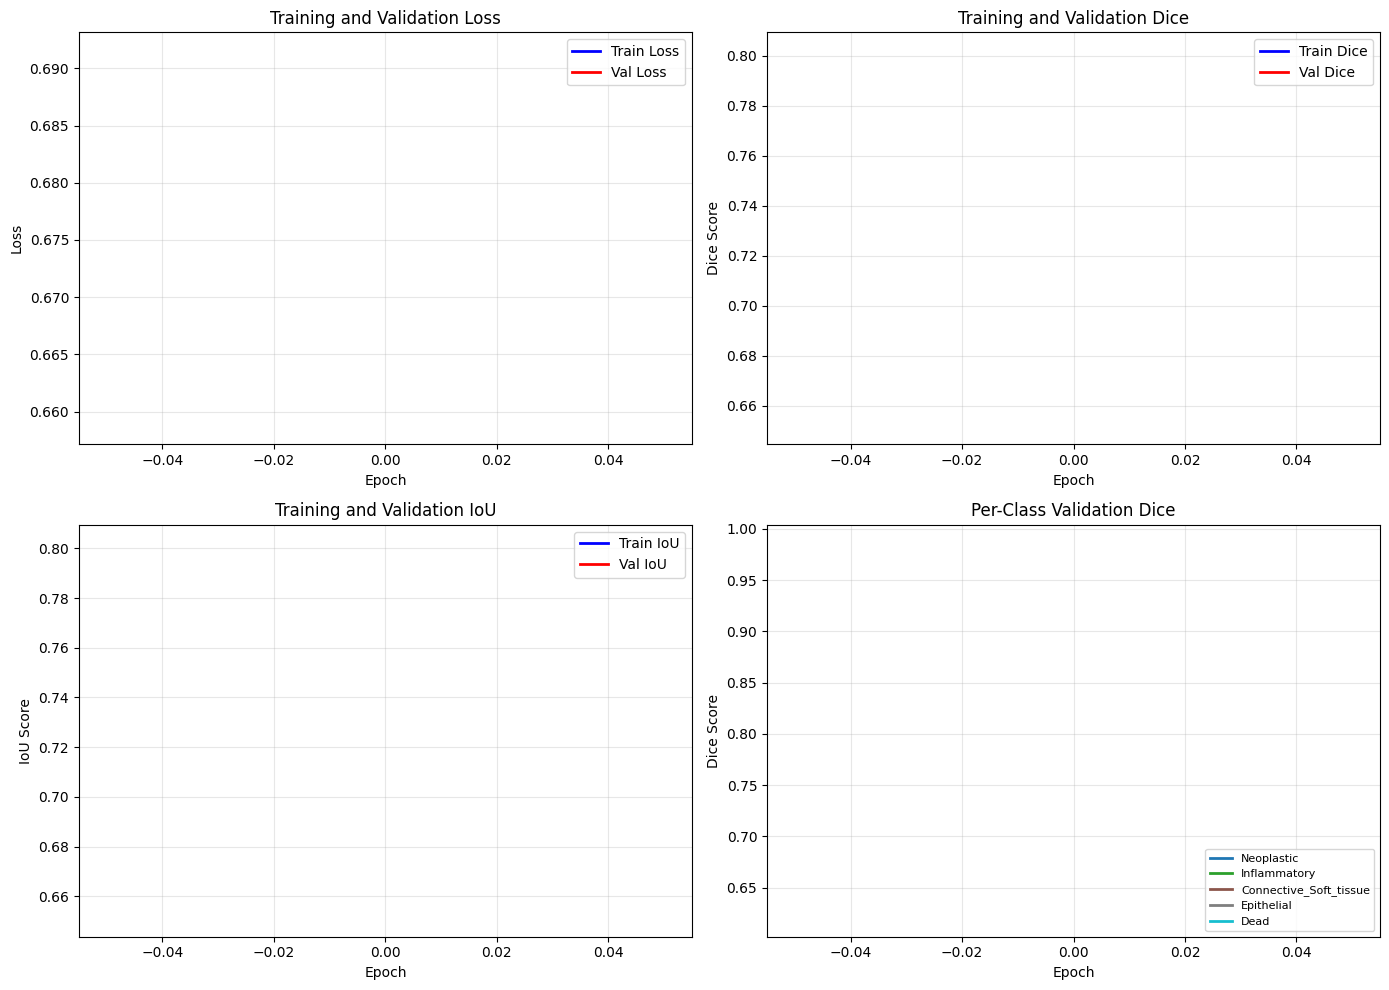


Final Per-Class Performance (Best Epoch)
  Neoplastic               : Dice=0.7646, IoU=0.7646
  Inflammatory             : Dice=0.7781, IoU=0.7781
  Connective_Soft_tissue   : Dice=0.6205, IoU=0.6205
  Epithelial               : Dice=0.8610, IoU=0.8610
  Dead                     : Dice=0.9858, IoU=0.9858


In [15]:
# Plot training history
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# Loss curves
ax1 = axes[0, 0]
ax1.plot(history['train_loss'], label='Train Loss', color='blue', linewidth=2)
ax1.plot(history['val_loss'], label='Val Loss', color='red', linewidth=2)
ax1.set_xlabel('Epoch')
ax1.set_ylabel('Loss')
ax1.set_title('Training and Validation Loss')
ax1.legend()
ax1.grid(True, alpha=0.3)

# Dice curves
ax2 = axes[0, 1]
ax2.plot(history['train_dice'], label='Train Dice', color='blue', linewidth=2)
ax2.plot(history['val_dice'], label='Val Dice', color='red', linewidth=2)
ax2.set_xlabel('Epoch')
ax2.set_ylabel('Dice Score')
ax2.set_title('Training and Validation Dice')
ax2.legend()
ax2.grid(True, alpha=0.3)

# IoU curves
ax3 = axes[1, 0]
ax3.plot(history['train_iou'], label='Train IoU', color='blue', linewidth=2)
ax3.plot(history['val_iou'], label='Val IoU', color='red', linewidth=2)
ax3.set_xlabel('Epoch')
ax3.set_ylabel('IoU Score')
ax3.set_title('Training and Validation IoU')
ax3.legend()
ax3.grid(True, alpha=0.3)

# Per-class Dice evolution
ax4 = axes[1, 1]
colors = plt.cm.tab10(np.linspace(0, 1, len(CLASS_NAMES)))
for i, class_name in enumerate(CLASS_NAMES):
    class_dice_history = [epoch_dice.get(class_name, 0) for epoch_dice in history['per_class_dice']]
    ax4.plot(class_dice_history, label=class_name, color=colors[i], linewidth=2)
ax4.set_xlabel('Epoch')
ax4.set_ylabel('Dice Score')
ax4.set_title('Per-Class Validation Dice')
ax4.legend(loc='lower right', fontsize=8)
ax4.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('compositional_training_history.png', dpi=150, bbox_inches='tight')
plt.show()

# Print final per-class summary
print("\n" + "="*60)
print("Final Per-Class Performance (Best Epoch)")
print("="*60)
best_epoch_idx = np.argmax(history['val_dice'])
best_per_class_dice = history['per_class_dice'][best_epoch_idx]
best_per_class_iou = history['per_class_iou'][best_epoch_idx]

for class_name in CLASS_NAMES:
    dice = best_per_class_dice.get(class_name, 0.0)
    iou = best_per_class_iou.get(class_name, 0.0)
    print(f"  {class_name:25s}: Dice={dice:.4f}, IoU={iou:.4f}")

In [16]:
for batch in val_loader:
    images = batch['image'].to(device)
    masks = batch['masks'].to(device)
    instructions = batch['instruction']

    outputs = model(images, instructions)

    pred_masks = outputs['masks']
    pred_sigmoid = torch.sigmoid(pred_masks)
    dice_per_class = dice_score(pred_sigmoid, masks, per_class=True)
    iou_per_class = iou_score(pred_sigmoid, masks, per_class=True)
    break

In [29]:
batch.keys()

dict_keys(['image', 'masks', 'instruction', 'class_presence', 'image_name'])

In [26]:
cp = batch['class_presence'][15]
cp

tensor([0., 1., 1., 0., 0.])

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


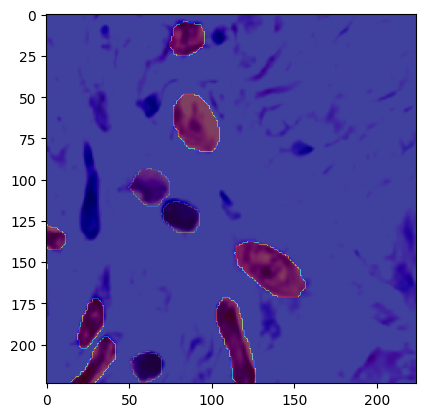

In [41]:
plt.imshow(batch['image'][15].permute(1, 2, 0))
plt.imshow(batch['masks'][15][1], alpha=0.5, cmap='jet')
plt.imshow(batch['masks'][15][2], alpha=0.5, cmap='jet')
plt.show()

In [43]:
pred_cp = outputs['class_presence']
pred_cg = outputs['class_guidance']

In [45]:
outputs.keys()

dict_keys(['masks', 'class_presence', 'grounded_features', 'class_guidance'])

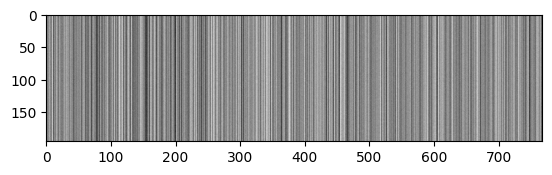

In [50]:
plt.imshow(outputs['grounded_features'][15].detach().cpu(), cmap='gray')

In [58]:
a=outputs['masks'][15].detach().cpu()
aa = torch.sigmoid(outputs['masks']).detach().cpu().numpy()[15]

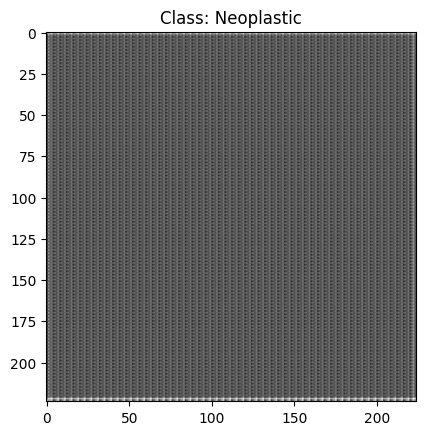

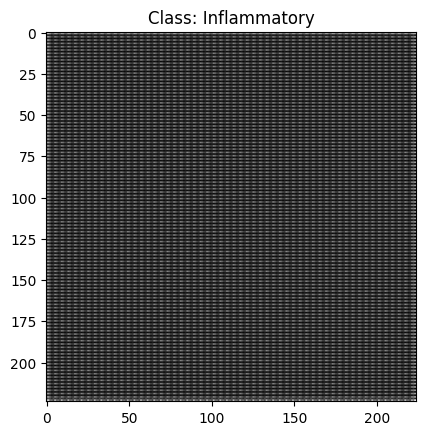

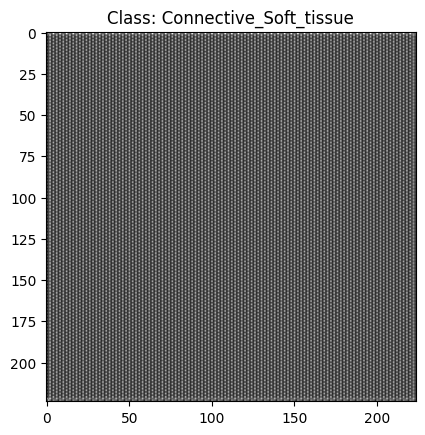

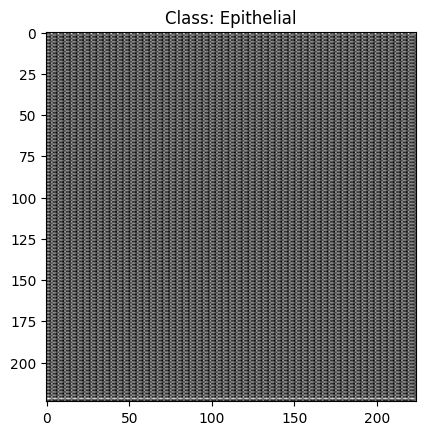

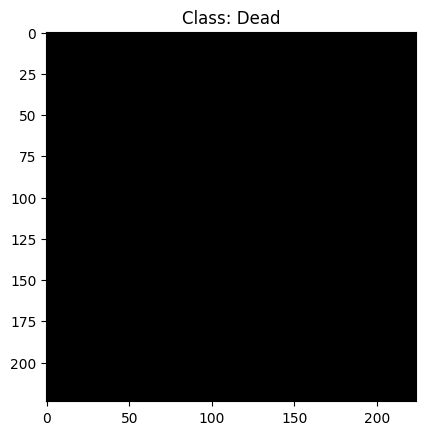

In [64]:
for i in range(5):
    # plt.imshow(batch['image'][15].permute(1, 2, 0))
    plt.imshow(aa[i], cmap='gray')
    plt.title(f"Class: {CLASS_NAMES[i]}")
    plt.show()


## 7. Compositional Query Visualization

This is the **key test** - the same image should produce different segmentation outputs based on which classes are mentioned in the text query.

In [ ]:
def visualize_compositional_segmentation(model, image_path, queries, class_names, device, img_size=224):
    """
    Demonstrate compositional text-conditional segmentation.
    Same image + different queries = different segmentation outputs.
    """
    model.eval()
    
    # Load and preprocess image (same as dataset class)
    image = cv2.imread(image_path)
    if image is None:
        raise FileNotFoundError(f"Image not found: {image_path}")
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    original_image = image.copy()
    
    # Resize
    image_resized = cv2.resize(image, (img_size, img_size))
    
    # Normalize (same as dataset class with albumentations)
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    image_normalized = (image_resized / 255.0 - mean) / std
    image_tensor = torch.from_numpy(image_normalized).permute(2, 0, 1).float().unsqueeze(0).to(device)
    
    # Color map for visualization
    colors = {
        'Neoplastic': [255, 0, 0],          # Red
        'Inflammatory': [0, 255, 0],         # Green
        'Connective_Soft_tissue': [0, 0, 255], # Blue
        'Dead': [255, 255, 0],               # Yellow
        'Epithelial': [255, 0, 255]          # Magenta
    }
    
    num_queries = len(queries)
    fig, axes = plt.subplots(2, num_queries + 1, figsize=(5 * (num_queries + 1), 10))
    
    # Show original image in first column
    axes[0, 0].imshow(cv2.resize(original_image, (img_size, img_size)))
    axes[0, 0].set_title('Original Image', fontsize=12, fontweight='bold')
    axes[0, 0].axis('off')
    axes[1, 0].axis('off')
    
    with torch.no_grad():
        for q_idx, query in enumerate(queries):
            # Get prediction for this query
            output = model(image_tensor, [query])
            pred = torch.sigmoid(output['masks']).cpu().numpy()[0]
            
            # Create overlay visualization
            overlay = cv2.resize(original_image, (img_size, img_size)).astype(np.float32)
            mask_combined = np.zeros((img_size, img_size, 3), dtype=np.float32)
            
            # Parse which classes are in this query
            query_classes = set()
            for class_name in class_names:
                if class_name.lower().replace('_', ' ') in query.lower() or class_name.lower() in query.lower():
                    query_classes.add(class_name)
            
            # Overlay each channel
            active_classes = []
            for ch_idx, class_name in enumerate(class_names):
                channel_pred = pred[ch_idx]
                binary_mask = (channel_pred > 0.5).astype(np.float32)
                
                if binary_mask.sum() > 0:
                    active_classes.append(class_name)
                    color = np.array(colors[class_name]) / 255.0
                    for c in range(3):
                        mask_combined[:, :, c] += binary_mask * color[c]
            
            # Blend with original
            alpha = 0.5
            mask_combined = np.clip(mask_combined, 0, 1)
            blended = overlay / 255.0 * (1 - alpha) + mask_combined * alpha
            blended = np.clip(blended, 0, 1)
            
            # Top row: overlay
            axes[0, q_idx + 1].imshow(blended)
            axes[0, q_idx + 1].set_title(f'Query: {query[:40]}...', fontsize=10, fontweight='bold')
            axes[0, q_idx + 1].axis('off')
            
            # Bottom row: individual channel predictions
            ax_bottom = axes[1, q_idx + 1]
            
            # Create a multi-channel visualization
            channel_vis = np.zeros((img_size, img_size * len(class_names), 3))
            for ch_idx, class_name in enumerate(class_names):
                channel_pred = pred[ch_idx]
                start_x = ch_idx * img_size
                # Grayscale to RGB
                for c in range(3):
                    channel_vis[:, start_x:start_x+img_size, c] = channel_pred
            
            ax_bottom.imshow(channel_vis, cmap='gray')
            ax_bottom.set_title(f'Active: {", ".join(active_classes) if active_classes else "None"}', fontsize=9)
            ax_bottom.axis('off')
    
    plt.tight_layout()
    plt.savefig('compositional_query_demo.png', dpi=150, bbox_inches='tight')
    plt.show()
    
    return fig

# Load best model
checkpoint = torch.load('best_cipsnet_compositional.pth', map_location=device)
model.load_state_dict(checkpoint['model_state_dict'])
print(f"Loaded best model from epoch {checkpoint['epoch']} with Dice: {checkpoint['best_dice']:.4f}")

# Get a sample image that has multiple classes
# FIXED: Use 'image_path' column (same as dataset class) instead of 'image_id'
sample_image_name = val_df['image_path'].iloc[0]
sample_image_path = os.path.join('Dataset', 'multi_images', sample_image_name)

# Define different compositional queries for the SAME image
test_queries = [
    "Segment Neoplastic tissue",
    "Segment Inflammatory cells",
    "Segment Neoplastic and Inflammatory",
    "Segment Connective Soft tissue and Epithelial",
    "Segment all: Neoplastic, Inflammatory, Connective Soft tissue, Dead, Epithelial"
]

print(f"\nTesting compositional queries on image: {sample_image_name}")
print("="*60)
for q in test_queries:
    print(f"  - {q}")
print("="*60)

# Visualize
visualize_compositional_segmentation(model, sample_image_path, test_queries, CLASS_NAMES, device)

## 8. Detailed Compositional Testing

Test the model's ability to understand different text queries and produce appropriate segmentation masks.

In [ ]:
def analyze_compositional_response(model, image_tensor, queries, class_names, device):
    """
    Quantitatively analyze how the model responds to different compositional queries.
    
    For true text-conditional segmentation:
    - Query for class A → high activation in channel A, low in others
    - Query for class A+B → high activation in channels A and B, low in others
    """
    model.eval()
    
    results = []
    
    with torch.no_grad():
        for query in queries:
            output = model(image_tensor, [query])
            pred = torch.sigmoid(output).cpu().numpy()[0]
            
            # Parse expected classes from query
            expected_classes = set()
            for class_name in class_names:
                if class_name.lower().replace('_', ' ') in query.lower() or class_name.lower() in query.lower():
                    expected_classes.add(class_name)
            
            # Calculate mean activation per channel
            activations = {}
            for ch_idx, class_name in enumerate(class_names):
                activations[class_name] = pred[ch_idx].mean()
            
            results.append({
                'query': query,
                'expected': expected_classes,
                'activations': activations
            })
    
    return results

# Get a validation sample
val_dataset_for_test = HistopathologyPermutationDataset(
    val_df, BASE_PATH, img_size=224, transform=None
)

# Pick a sample with multiple classes present
test_idx = 0
test_sample = val_dataset_for_test[test_idx]
test_image = test_sample['image'].unsqueeze(0).to(device)
test_text = test_sample['text']

print(f"Original query from dataset: {test_text}")
print(f"\nTesting compositional understanding...\n")

# Test different compositional queries
compositional_queries = [
    "Segment Neoplastic tissue only",
    "Segment Inflammatory cells only",
    "Segment Neoplastic and Inflammatory",
    "Segment Connective Soft tissue only",
    "Segment Dead cells only",
    "Segment Epithelial tissue only",
    "Segment Neoplastic, Inflammatory, and Connective Soft tissue",
    "Segment all tissue types: Neoplastic, Inflammatory, Connective Soft tissue, Dead, Epithelial"
]

results = analyze_compositional_response(model, test_image, compositional_queries, CLASS_NAMES, device)

# Display results as a table
print("="*100)
print(f"{'Query':<55} | {'Expected Classes':<30} | Channel Activations")
print("="*100)

for r in results:
    query_short = r['query'][:52] + "..." if len(r['query']) > 55 else r['query']
    expected_str = ", ".join(sorted(r['expected']))[:28] if r['expected'] else "None"
    
    # Format activations
    act_parts = []
    for class_name in CLASS_NAMES:
        act = r['activations'][class_name]
        # Highlight if expected vs not expected
        if class_name in r['expected']:
            act_parts.append(f"{class_name[:3]}:{act:.3f}*")
        else:
            act_parts.append(f"{class_name[:3]}:{act:.3f}")
    
    print(f"{query_short:<55} | {expected_str:<30} | {' '.join(act_parts)}")

print("="*100)
print("\n* = Expected to be high based on query")
print("\nIdeal behavior: Marked channels (*) should have higher activations than unmarked ones.")

## 9. Side-by-Side Comparison: Query vs Ground Truth

Visualize the model's predictions alongside ground truth for specific compositional queries.

In [ ]:
def visualize_prediction_vs_ground_truth(model, dataset, indices, device, class_names):
    """
    Compare model predictions with ground truth masks for compositional queries.
    """
    model.eval()
    
    colors = {
        'Neoplastic': [255, 0, 0],
        'Inflammatory': [0, 255, 0],
        'Connective_Soft_tissue': [0, 0, 255],
        'Dead': [255, 255, 0],
        'Epithelial': [255, 0, 255]
    }
    
    num_samples = len(indices)
    fig, axes = plt.subplots(num_samples, 4, figsize=(16, 4 * num_samples))
    
    if num_samples == 1:
        axes = axes.reshape(1, -1)
    
    with torch.no_grad():
        for row, idx in enumerate(indices):
            sample = dataset[idx]
            image = sample['image'].unsqueeze(0).to(device)
            mask_gt = sample['mask'].numpy()
            query = sample['text']
            
            # Get prediction
            output = model(image, [query])
            pred = torch.sigmoid(output).cpu().numpy()[0]
            
            # Convert image for display
            img_display = sample['image'].permute(1, 2, 0).numpy()
            img_display = img_display * np.array([0.229, 0.224, 0.225]) + np.array([0.485, 0.456, 0.406])
            img_display = np.clip(img_display, 0, 1)
            
            # Create overlays
            gt_overlay = np.zeros((*mask_gt.shape[1:], 3))
            pred_overlay = np.zeros((*pred.shape[1:], 3))
            
            for ch_idx, class_name in enumerate(class_names):
                color = np.array(colors[class_name]) / 255.0
                
                # Ground truth
                gt_mask = mask_gt[ch_idx] > 0.5
                for c in range(3):
                    gt_overlay[:, :, c] += gt_mask * color[c]
                
                # Prediction
                pred_mask = pred[ch_idx] > 0.5
                for c in range(3):
                    pred_overlay[:, :, c] += pred_mask * color[c]
            
            gt_overlay = np.clip(gt_overlay, 0, 1)
            pred_overlay = np.clip(pred_overlay, 0, 1)
            
            # Plot
            axes[row, 0].imshow(img_display)
            axes[row, 0].set_title('Input Image', fontsize=10)
            axes[row, 0].axis('off')
            
            axes[row, 1].imshow(gt_overlay)
            axes[row, 1].set_title('Ground Truth', fontsize=10)
            axes[row, 1].axis('off')
            
            axes[row, 2].imshow(pred_overlay)
            axes[row, 2].set_title('Prediction', fontsize=10)
            axes[row, 2].axis('off')
            
            # Difference map
            diff = np.abs(gt_overlay - pred_overlay)
            axes[row, 3].imshow(diff)
            axes[row, 3].set_title('Difference', fontsize=10)
            axes[row, 3].axis('off')
            
            # Add query as row label
            fig.text(0.02, (num_samples - row - 0.5) / num_samples, 
                     f'Query: {query[:60]}...', fontsize=9, va='center', ha='left',
                     bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.5))
    
    # Add legend
    legend_elements = [plt.Rectangle((0, 0), 1, 1, facecolor=np.array(colors[c])/255.0, label=c) 
                       for c in class_names]
    fig.legend(handles=legend_elements, loc='upper center', ncol=5, fontsize=9, 
               bbox_to_anchor=(0.5, 0.02))
    
    plt.tight_layout()
    plt.subplots_adjust(bottom=0.08, left=0.15)
    plt.savefig('prediction_vs_ground_truth.png', dpi=150, bbox_inches='tight')
    plt.show()

# Visualize a few validation samples
test_indices = [0, 10, 20, 30]  # Adjust based on dataset size
test_indices = [i for i in test_indices if i < len(val_dataset_for_test)]

print(f"Comparing predictions vs ground truth for {len(test_indices)} samples...")
visualize_prediction_vs_ground_truth(model, val_dataset_for_test, test_indices, device, CLASS_NAMES)